# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | This time British Airways ...
1,"✅ Trip Verified | The seats were excellent, ..."
2,✅ Trip Verified | After the nightmare of get...
3,✅ Trip Verified | Prior to boarding a gate a...
4,✅ Trip Verified | I flew from Amsterdam to L...


In [4]:
df.to_csv("BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

## Data Manipulation

In [5]:
import pandas as pd

# Define the file path
file_path = "data/BA_reviews.csv"

# Load the dataset
df = pd.read_csv(file_path)

# Display basic information about the dataset
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1000 non-null   int64 
 1   reviews     1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


(None,
    Unnamed: 0                                            reviews
 0           0  ✅ Trip Verified |   Prior to boarding a gate a...
 1           1  ✅ Trip Verified |   I flew from Amsterdam to L...
 2           2  ✅ Trip Verified | First the good news, the clu...
 3           3  ✅ Trip Verified |   I have never travelled wit...
 4           4  ✅ Trip Verified | Terrible overall, medium ser...)

In [6]:
import re

# Remove the unnecessary column
df = df.drop(columns=["Unnamed: 0"])

# Check for missing values
missing_values = df.isnull().sum()

# Remove duplicate reviews if any
df = df.drop_duplicates()

# Clean the text: remove special characters and extra spaces
df["cleaned_reviews"] = df["reviews"].apply(lambda x: re.sub(r"[^\w\s]", "", x).strip())

# Display the cleaned data
df.head(), missing_values

(                                             reviews  \
 0  ✅ Trip Verified |   Prior to boarding a gate a...   
 1  ✅ Trip Verified |   I flew from Amsterdam to L...   
 2  ✅ Trip Verified | First the good news, the clu...   
 3  ✅ Trip Verified |   I have never travelled wit...   
 4  ✅ Trip Verified | Terrible overall, medium ser...   
 
                                      cleaned_reviews  
 0  Trip Verified    Prior to boarding a gate agen...  
 1  Trip Verified    I flew from Amsterdam to Las ...  
 2  Trip Verified  First the good news the club su...  
 3  Trip Verified    I have never travelled with B...  
 4  Trip Verified  Terrible overall medium service...  ,
 reviews    0
 dtype: int64)

In [7]:
from textblob import TextBlob

# Function to determine sentiment polarity
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment analysis
df["sentiment"] = df["cleaned_reviews"].apply(get_sentiment)

# Count sentiment categories
sentiment_counts = df["sentiment"].value_counts()

# Display sentiment distribution
sentiment_counts


sentiment
Positive    613
Negative    375
Neutral      12
Name: count, dtype: int64

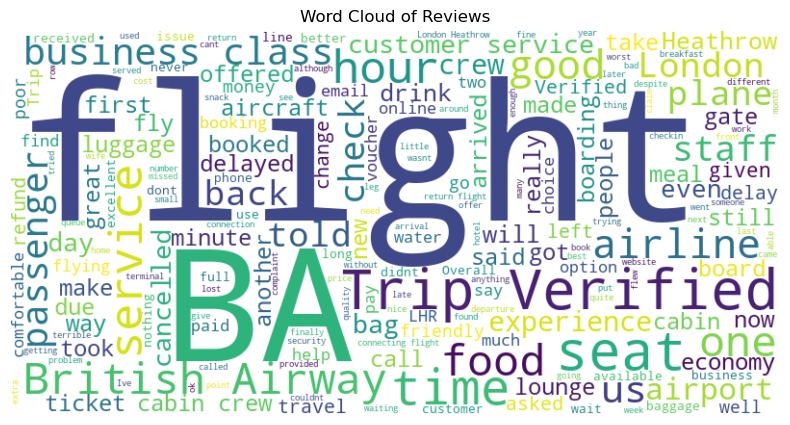

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create a word cloud of the reviews
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(df["cleaned_reviews"]))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Reviews")
plt.show()


In [9]:
# Perform topic modeling with LDA
vectorizer = CountVectorizer(stop_words="english", max_features=1000)
X = vectorizer.fit_transform(df["cleaned_reviews"])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Display the top words in each topic
words = vectorizer.get_feature_names_out()
topics = {}
for topic_idx, topic in enumerate(lda.components_):
    topics[f"Topic {topic_idx+1}"] = [words[i] for i in topic.argsort()[-10:]]

topics

{'Topic 1': ['crew',
  'seat',
  'service',
  'class',
  'food',
  'trip',
  'good',
  'ba',
  'verified',
  'flight'],
 'Topic 2': ['trip',
  'gate',
  'cabin',
  'boarding',
  'crew',
  'verified',
  'passengers',
  'flight',
  'staff',
  'ba'],
 'Topic 3': ['trip',
  'told',
  'refund',
  'airways',
  'verified',
  'service',
  'british',
  'customer',
  'ba',
  'flight'],
 'Topic 4': ['luggage',
  'hours',
  'london',
  'airport',
  'trip',
  'ba',
  'airways',
  'verified',
  'british',
  'flight'],
 'Topic 5': ['hours',
  'day',
  'return',
  'flights',
  'trip',
  'time',
  'cancelled',
  'verified',
  'ba',
  'flight']}

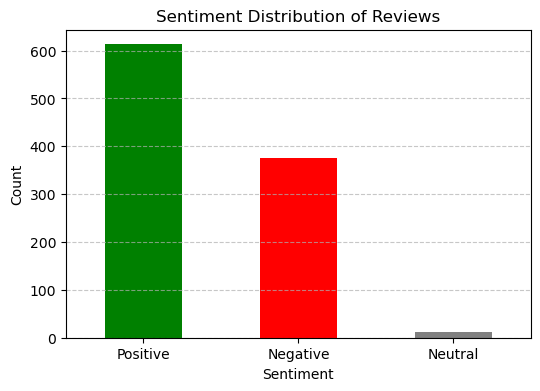

In [10]:
import matplotlib.pyplot as plt

# Plot sentiment distribution
plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind="bar", color=["green", "red", "gray"])
plt.title("Sentiment Distribution of Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


AttributeError: 'numpy.int64' object has no attribute 'keys'

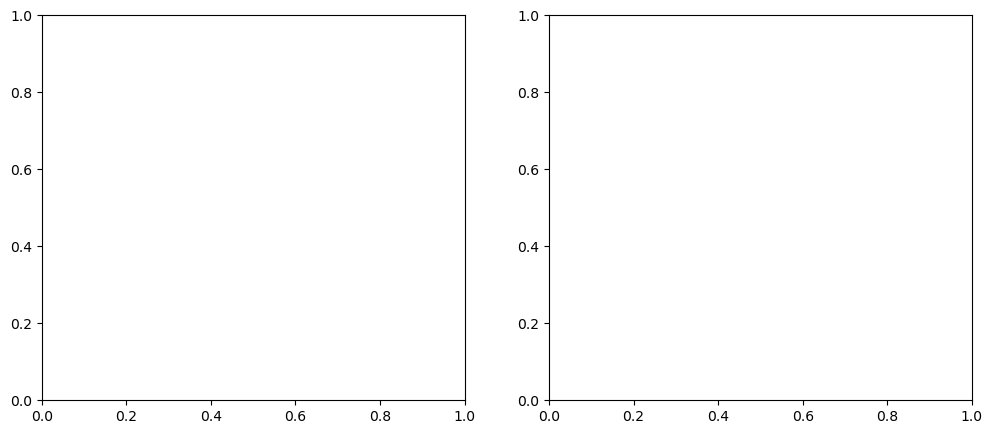

In [11]:
# Plot most common words in positive and negative reviews
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Positive Words
axes[0].barh(list(sentiment_counts.Positive.keys()), list(sentiment_counts.Positive.values()), color="green")
axes[0].set_title("Top Words in Positive Reviews")
axes[0].invert_yaxis()

# Negative Words
axes[1].barh(list(sentiment_counts.Negative.keys()), list(sentiment_counts.Negative.values()), color="red")
axes[1].set_title("Top Words in Negative Reviews")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


In [12]:
sentiment_counts.Positive

613